In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import presentation as p 

In [3]:
training_df = pd.read_csv('data/network-traffic/kddcup.data.corrected.csv', index_col=False).drop_duplicates()
testing_df = pd.read_csv('data/network-traffic/corrected.csv', index_col=False).drop_duplicates()
complete_df = pd.read_csv('data/network-traffic/kddcup.data.complete.csv', index_col=False).drop_duplicates()

complete_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack_class
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal,normal


In [4]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074992 entries, 0 to 1074991
Data columns (total 43 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   duration                     1074992 non-null  int64  
 1   protocol_type                1074992 non-null  object 
 2   service                      1074992 non-null  object 
 3   flag                         1074992 non-null  object 
 4   src_bytes                    1074992 non-null  int64  
 5   dst_bytes                    1074992 non-null  int64  
 6   land                         1074992 non-null  int64  
 7   wrong_fragment               1074992 non-null  int64  
 8   urgent                       1074992 non-null  int64  
 9   hot                          1074992 non-null  int64  
 10  num_failed_logins            1074992 non-null  int64  
 11  logged_in                    1074992 non-null  int64  
 12  num_compromised              1074992 non-n

In [5]:
# Create column to verify if it is an attack or not
training_df['is_attack'] = training_df.target.map(lambda a_type: a_type != 'normal')
testing_df['is_attack'] = testing_df.target.map(lambda a_type: a_type != 'normal')
complete_df['is_attack'] = complete_df.target.map(lambda a_type: a_type != 'normal')

In [6]:
# Label encode the target and categorical variables
categorical_columns = ['protocol_type', 'service', 'flag', 'target', 'attack_class', 'is_attack']

label_encoder = LabelEncoder()

for col in categorical_columns:
    training_df[col] = label_encoder.fit_transform(training_df[col])
    testing_df[col] = label_encoder.fit_transform(testing_df[col])
    complete_df[col] = label_encoder.fit_transform(complete_df[col])

In [7]:
training_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target', 'attack_class', 'is_attack'],
      dtype='object')

# Metrcis and reduced Dataset

In [8]:
# Metrics
beta = 10
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

In [9]:
# Important Data Subset (15 Most Important Features)
relevant_columns_attack = [
   'same_srv_rate', 'count', 'diff_srv_rate', 'src_bytes', 'flag', 'dst_host_srv_serror_rate', 
   'dst_bytes', 'dst_host_same_srv_rate', 'srv_serror_rate', 'serror_rate', 'service', 
   'dst_host_serror_rate', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'protocol_type'
]

# Baseline Models for Attack Detection

In [10]:
# Split data into features (X) and target (y)
X_train_attack = training_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_attack = training_df['is_attack']

X_test_attack = testing_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_attack = testing_df['is_attack']

In [11]:
scaler = StandardScaler()
X_train_attack_scaled = scaler.fit_transform(X_train_attack)
X_test_attack_scaled = scaler.transform(X_test_attack)


# KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
# Train the KNN model
knn_model_attack = KNeighborsClassifier(n_neighbors=100)
knn_model_attack.fit(X_train_attack_scaled, y_train_attack)

KNeighborsClassifier(n_neighbors=100)

In [15]:
# Make predictions
knn_attack_pred = knn_model_attack.predict(X_test_attack_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test_attack, knn_attack_pred)
fbeta = fbeta_score(y_test_attack, knn_attack_pred, beta=beta)
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_attack, knn_attack_pred))


Accuracy: 0.9361503926718505, F-beta Score: 0.8408800248692995
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     47913
           1       0.99      0.84      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.93     77291



Confusion Matrix Attack Detection KNN


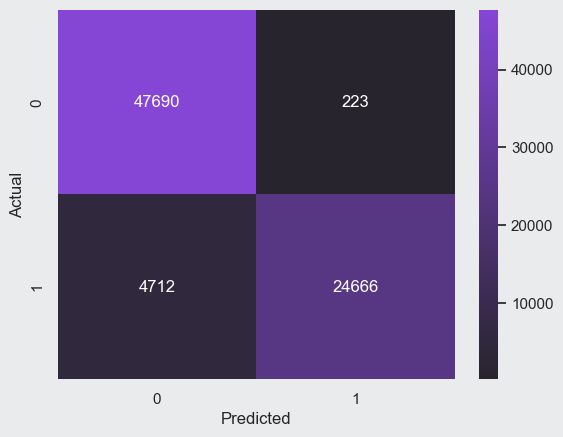

In [16]:
# Print Confusion Matrix 
print('Confusion Matrix Attack Detection KNN')
conf_matrix_attack = confusion_matrix(y_test_attack, knn_attack_pred)
sns.heatmap(conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [18]:
# Train the Naive Bayes model
nb_model_attack = GaussianNB()
nb_model_attack.fit(X_train_attack_scaled, y_train_attack)

GaussianNB()

In [19]:
# Predict on the test set
nb_attack_pred = nb_model_attack.predict(X_test_attack_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test_attack, knn_attack_pred)
fbeta = fbeta_score(y_test_attack, nb_attack_pred, beta=beta)
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_attack, knn_attack_pred))

Accuracy: 0.9361503926718505, F-beta Score: 0.8430943741810872
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     47913
           1       0.99      0.84      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.93     77291



Confusion Matrix Attack Detection Naive Bayes


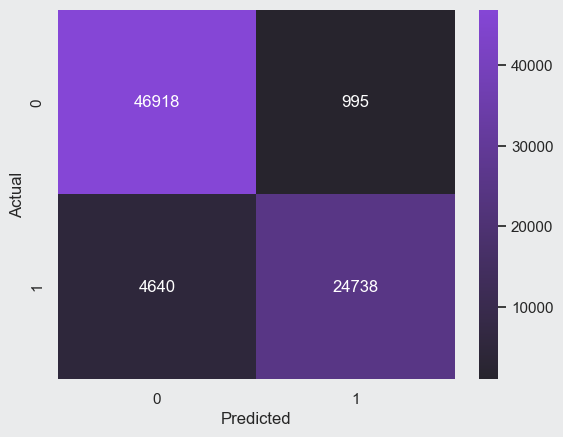

In [20]:
# Print Confusion Matrix
print('Confusion Matrix Attack Detection Naive Bayes')
conf_matrix_attack = confusion_matrix(y_test_attack, nb_attack_pred)
sns.heatmap(conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
#Train the LR Model
lr_model_attack = LogisticRegression(max_iter= 1000)
lr_model_attack.fit(X_train_attack_scaled, y_train_attack)

LogisticRegression(max_iter=1000)

In [23]:
# Predict on the test set
lr_attack_pred = lr_model_attack.predict(X_test_attack_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test_attack, lr_attack_pred)
fbeta = fbeta_score(y_test_attack, lr_attack_pred, beta=beta)
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_attack, lr_attack_pred))

Accuracy: 0.9146989947083102, F-beta Score: 0.7982587134386038
              precision    recall  f1-score   support

           0       0.89      0.99      0.93     47913
           1       0.97      0.80      0.88     29378

    accuracy                           0.91     77291
   macro avg       0.93      0.89      0.91     77291
weighted avg       0.92      0.91      0.91     77291



Confusion Matrix Attack Detection Logistic Regression


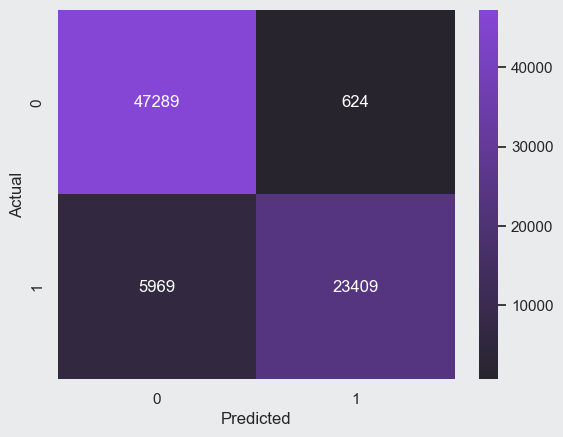

In [24]:
# Print Confusion Matrix
print('Confusion Matrix Attack Detection Logistic Regression')
conf_matrix_attack = confusion_matrix(y_test_attack, lr_attack_pred)
sns.heatmap(conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Support Vector Machine

In [25]:
from sklearn.svm import SVC

In [26]:
svm_model_attack = SVC()
svm_model_attack.fit(X_train_attack_scaled, y_train_attack)

SVC()

In [27]:
# Predict on the test set
svm_attack_pred = svm_model_attack.predict(X_test_attack_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test_attack, svm_attack_pred)
fbeta = fbeta_score(y_test_attack, svm_attack_pred, beta=beta)
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_attack, svm_attack_pred))

Accuracy: 0.9285686561177886, F-beta Score: 0.8202938025838126
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     47913
           1       0.99      0.82      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291



Confusion Matrix Attack Detection SVM


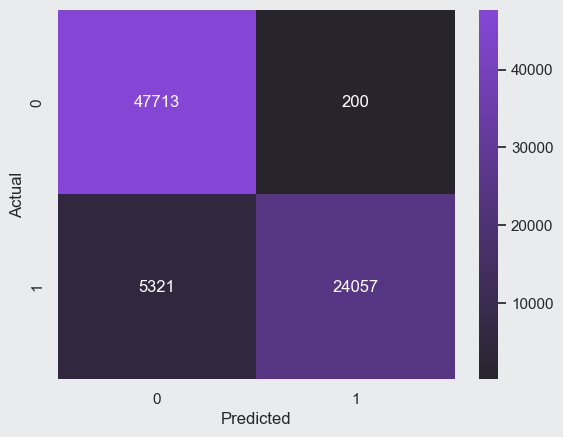

In [29]:
# Print Confusion Matrix
print('Confusion Matrix Attack Detection SVM')
conf_matrix_attack = confusion_matrix(y_test_attack, svm_attack_pred)
sns.heatmap(conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Baseline Models for Attack Class

In [30]:
# Metrics
beta = 10
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

In [31]:
# Important Data Subset (15 Most Important Features)
relevant_columns_class = [
    'count', 'dst_host_diff_srv_rate', 'diff_srv_rate', 'dst_host_same_src_port_rate', 'src_bytes',
    'same_srv_rate', 'srv_count', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
    'dst_host_rerror_rate', 'flag', 'dst_host_count', 'dst_host_srv_count', 'rerror_rate', 'service'
]

In [32]:
# Split data into features (X) and target (y)
X_train_class = training_df[training_df['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_class = training_df[training_df['attack_class'] != 1]['attack_class']

X_test_class = testing_df[testing_df['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_class = testing_df[testing_df['attack_class'] != 1]['attack_class']

In [33]:
scaler = StandardScaler()
X_train_class_scaled = scaler.fit_transform(X_train_class)
X_test_class_scaled = scaler.transform(X_test_class)

# KNN